In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import IPython.display as display
AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)
print(hub.__version__)

2.2.0
0.8.0


## Reading file pattern for multiple parts

Specify the directory path where `tfrecord` files are stored. `root_dir` is the path of your local file system right down to the folder where `tfrecord` files are stored. In the cell below, you see an example path for `root_dir`. Notice the use of wild card `*` for referring to multiple parts as a file pattern.

In [2]:
root_dir = '/Users/XXXXX/Documents/tf_datasets/flower_photos'
train_file_pattern = "{}/image_classification_builder-train*.tfrecord*".format(root_dir)
val_file_pattern = "{}/image_classification_builder-validation*.tfrecord*".format(root_dir)
test_file_pattern = "{}/image_classification_builder-test*.tfrecord*".format(root_dir)

`tf.io` API are helpful in defining a file path pattern. It is passed into a dataset object.

In [3]:
tf.io.gfile.glob(train_file_pattern)

['/Users/mbp16/Documents/tf_datasets/flower_photos/image_classification_builder-train.tfrecord-00001-of-00002',
 '/Users/mbp16/Documents/tf_datasets/flower_photos/image_classification_builder-train.tfrecord-00000-of-00002']

In [4]:
train_all_files = tf.data.Dataset.list_files( tf.io.gfile.glob(train_file_pattern))
val_all_files = tf.data.Dataset.list_files( tf.io.gfile.glob(val_file_pattern))
test_all_files = tf.data.Dataset.list_files( tf.io.gfile.glob(test_file_pattern))

The dataset object is passed into a `TFRecord` reader object, which yields a dataset.

In [5]:
train_all_ds = tf.data.TFRecordDataset(train_all_files, num_parallel_reads = AUTOTUNE)
val_all_ds = tf.data.TFRecordDataset(val_all_files, num_parallel_reads = AUTOTUNE)
test_all_ds = tf.data.TFRecordDataset(test_all_files, num_parallel_reads = AUTOTUNE)

## Determing sample size in TFRecord

In [6]:
print("Sample size for training: {0}".format(sum(1 for _ in tf.data.TFRecordDataset(train_all_files)))
     ,'\n', "Sample size for validation: {0}".format(sum(1 for _ in tf.data.TFRecordDataset(val_all_files)))
     ,'\n', "Sample size for test: {0}".format(sum(1 for _ in tf.data.TFRecordDataset(test_all_files))))

Sample size for training: 3540 
 Sample size for validation: 80 
 Sample size for test: 50


## Parsing TFRecord

These are feature descriptions used for creating the `TFRecord` from raw images. Use this again for parsing the `TFRecord`, so that we have the right name to parse these features from a given `TFRecord`.

In [7]:
feature_description = {
    'image/channels' :  tf.io.FixedLenFeature([], tf.int64),
    'image/class/label' :  tf.io.FixedLenFeature([], tf.int64),
    'image/class/text' : tf.io.FixedLenFeature([], tf.string),
    'image/colorspace' : tf.io.FixedLenFeature([], tf.string),
    'image/encoded' : tf.io.FixedLenFeature([], tf.string),
    'image/filename' : tf.io.FixedLenFeature([], tf.string),
    'image/format' : tf.io.FixedLenFeature([], tf.string),
    'image/height' : tf.io.FixedLenFeature([], tf.int64),
    'image/width' : tf.io.FixedLenFeature([], tf.int64)
}

In [8]:
def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

Apply the parse function to each reacord in the dataset.

In [9]:
parsd_ds = train_all_ds.map(_parse_function)

## Mapping label dictionary

Create a label map from the dataset.

In [10]:
label_map = {}
# getting label mapping
for image_features in parsd_ds.shuffle(1024).take(100):
    label_idx = image_features['image/class/label'].numpy()
    label_str = image_features['image/class/text'].numpy().decode()
    if label_idx not in label_map:
        label_map[label_idx] = label_str

In [11]:
label_map

{3: 'dandelion', 0: 'roses', 4: 'tulips', 1: 'sunflowers', 2: 'daisy'}

In [12]:
val_parsd_ds = val_all_ds.map(_parse_function)

In [13]:
val_label_map = {}
# getting label mapping
for image_features in val_parsd_ds.take(80):
    label_idx = image_features['image/class/label'].numpy()
    label_str = image_features['image/class/text'].numpy().decode()
    if label_idx not in val_label_map:
        val_label_map[label_idx] = label_str

In [14]:
val_label_map

{4: 'tulips', 0: 'roses', 1: 'sunflowers', 3: 'dandelion', 2: 'daisy'}

## Showing content of example protobuf

For inspection, lets take a look at one observation from the validation dataset. 

In [19]:
parsed_examples_dict = {}
for raw_record in val_all_ds.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    parsed_example = tf.io.parse_single_example(raw_record, feature_description)
    parsed_examples_dict.update(parsed_example)
    image = tf.io.decode_jpeg(parsed_example['image/encoded'], channels = 3)
    label_idx = tf.cast(parsed_example['image/class/label'], tf.int64)
    label = tf.cast(parsed_example['image/class/text'], tf.string)

This is a dictionary that demonstrate what this observation contains.

In [20]:
parsed_examples_dict # show key-value pairs in the example protobuf

{'image/channels': <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 'image/class/label': <tf.Tensor: shape=(), dtype=int64, numpy=4>,
 'image/class/text': <tf.Tensor: shape=(), dtype=string, numpy=b'tulips'>,
 'image/colorspace': <tf.Tensor: shape=(), dtype=string, numpy=b'RGB'>,
 'image/encoded': <tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00\xf0\x01@\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04

Now let's encode the image byte string into jpeg and show it with its corresponding label.

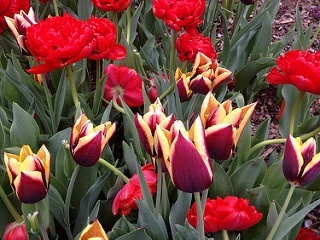

tf.Tensor(b'tulips', shape=(), dtype=string)


In [22]:
encoded_jpeg = tf.io.encode_jpeg(image.numpy(), format = 'rgb')
display.display(display.Image(data=encoded_jpeg.numpy()))
print(label)

This image is labeled as tulips. It is correct. 